# Модель монетизации компьютерной игры 

# Материалы

* [Ссылка на презентацию] (https://drive.google.com/file/d/1hqbd9F0e_He3bB3xl6m67f-WqlYQ3_Dp/view?usp=sharing)

* [Ссылка на дашборд] (https://public.tableau.com/views/__16475595931380/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

## Введение

Целью проекта является формирование модели монетизации игры. Необходимо рассчитать, где и в каком количестве нужно показывать рекламу, чтобы игра приносила прибыль, при этом не отталкивая пользователей слишком большим количеством рекламы. Изначально предполагается показывать рекламу на экране постройки после каждого построенного объекта. Необходимо оценить жизнеспособность такой модели на тестовой когорте пользователей. При необходимости оптимизировать базовую модель или предложить альтернативный вариант.

Известно, что каждый показ рекламы приносит компании 7 центов.

Описание данных:

Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет *ad_cost.csv* содержит колонки:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

## Импорт и предобработка данных

In [1]:
# импортируем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from scipy import stats as st

from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()

In [2]:
# pip install -U seaborn

### Знакомство с данными

In [3]:
# импортируем датасеты
ad_costs = pd.read_csv('/datasets/ad_costs.csv')
user_source = pd.read_csv('/datasets/user_source.csv')
game_actions = pd.read_csv('/datasets/game_actions.csv')

Напишем функцию, которая выводит первые пять строк таблицы, информацию о таблице, а также количество пропусков и дубликатов.

In [4]:
# определение функции info()
def info(data):
    display(data.head())
    print('--' * 50)
    print('Информация о таблице')
    display(data.info())
    print('--' * 50)
    print('Количество пропусков')
    display(data.isnull().sum())
    print('--' * 50)
    print('Количество дубликатов')
    display(data.duplicated().sum())
    print('--' * 50)

Применим функцию ко всем таблицам:

In [5]:
for i in list([game_actions,ad_costs,user_source]):
    info(i)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


----------------------------------------------------------------------------------------------------
Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

----------------------------------------------------------------------------------------------------
Количество пропусков


event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

----------------------------------------------------------------------------------------------------
Количество дубликатов


1

----------------------------------------------------------------------------------------------------


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


----------------------------------------------------------------------------------------------------
Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

----------------------------------------------------------------------------------------------------
Количество пропусков


source    0
day       0
cost      0
dtype: int64

----------------------------------------------------------------------------------------------------
Количество дубликатов


0

----------------------------------------------------------------------------------------------------


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


----------------------------------------------------------------------------------------------------
Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


None

----------------------------------------------------------------------------------------------------
Количество пропусков


user_id    0
source     0
dtype: int64

----------------------------------------------------------------------------------------------------
Количество дубликатов


0

----------------------------------------------------------------------------------------------------


В таблице `game_actions` много пропусков в столбцах `building_type` и `project_type`, нужно узнать, что они из себя представляют и решить, что с ними делать. Также найдет 1 дубликат, его можно удалить. С остальными таблицами на первый взгляд всё в порядке.

### Предобработка данных

* **Исследование пропусков**

Посмотрим, какие уникальные значения содержатся в столбцах `building_type`, `project_type` и `event`:

In [6]:
for i in game_actions['event'],game_actions['building_type'], game_actions['project_type']:    
    print(i.unique())

['building' 'finished_stage_1' 'project']
['assembly_shop' 'spaceport' nan 'research_center']
[nan 'satellite_orbital_assembly']


В столбце `event` находятся события, которые совершали пользователи: постройка здания, завершение уровня или завершение проекта. В столбце `building_type` записаны типы построек. Скорее всего, пропуски из столбца `building_type` соотвествуют событиям, которые не связаны со строительством. Проверим:

In [7]:
game_actions.query('building_type.isnull()').groupby('event')['user_id'].count()

event
finished_stage_1    5817
project             1866
Name: user_id, dtype: int64

Так и есть, пропуски в столбце `building_type` соотвествуют событиям, не связанным с строительством. Значит, они логичны и удалять их не нужно.

Скорее всего, пропуски в столбце `project_type` так же соответсвуют событиям, не связнным с завершением проекта. Проверим это:

In [8]:
game_actions.query('project_type.isnull()').groupby('event')['user_id'].count()

event
building            127957
finished_stage_1      5817
Name: user_id, dtype: int64

Подтверждается, значит и эти пропуски нормальны, удалять их не нужно.

* **Обработка дубликатов**

В таблице `game_actions` всего один полный дубликат, можем им пожертвовать.

In [9]:
# удаляем дубликаты
game_actions = game_actions.drop_duplicates()
game_actions.duplicated().sum()

0

* **Приведение типов данных**

Столбцы, содержащие дату и время имеет смысл привести к типу datetime:

In [10]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
ad_costs['day'] = pd.to_datetime(ad_costs['day'])

**Вывод:** дубликаты удалены, столбцы с датой и временем приведены к типу datetime, пропуски решено не удалять. Данные обработаны и готовы к анализу.

## Исследовательский анализ данных

### Активность пользователей. Количество активных пользователей в день/неделю/час

Добавим отдельные столбцы с датой, неделец и часом события:

In [11]:
game_actions['event_date'] = game_actions['event_datetime'].dt.date
game_actions['event_hour'] = game_actions['event_datetime'].dt.hour
game_actions['event_week'] = game_actions['event_datetime'].dt.week

/tmp/ipykernel_53/3341245145.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  game_actions['event_week'] = game_actions['event_datetime'].dt.week


Расчитаем метрики DAU,WAU и количество уникальных пользователей в час, чтобы оценить суточную динамику:

In [12]:
dau = game_actions.groupby('event_date').agg({'user_id':'nunique'}).rename(columns={'user_id':'user_nunique'})
wau = game_actions.groupby('event_week').agg({'user_id':'nunique'}).rename(columns={'user_id':'user_nunique'})
users_per_hour = game_actions.groupby('event_hour').agg({'user_id':'nunique'}).rename(columns={'user_id':'user_nunique'})

print('Cреднее количество пользователей в день', round(dau['user_nunique'].mean(),0))
print('Cреднее количество пользователей в неделю', round(wau['user_nunique'].mean(),0))
print('Cреднее количество пользователей в час', round(users_per_hour['user_nunique'].mean(),0))

Cреднее количество пользователей в день 2885.0
Cреднее количество пользователей в неделю 6120.0
Cреднее количество пользователей в час 4571.0


Создадим функцию для линейных графиков:

In [13]:
def lineplot(data,x,y,title,xlabel,ylabel):
    plt.figure(figsize=(16,9))
    sns.lineplot(data=data, x=x, y=y)
    plt.title(title,fontsize=20)
    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel(ylabel,fontsize=15)
    plt.show()

Построим графики по рассчитанным метрикам:

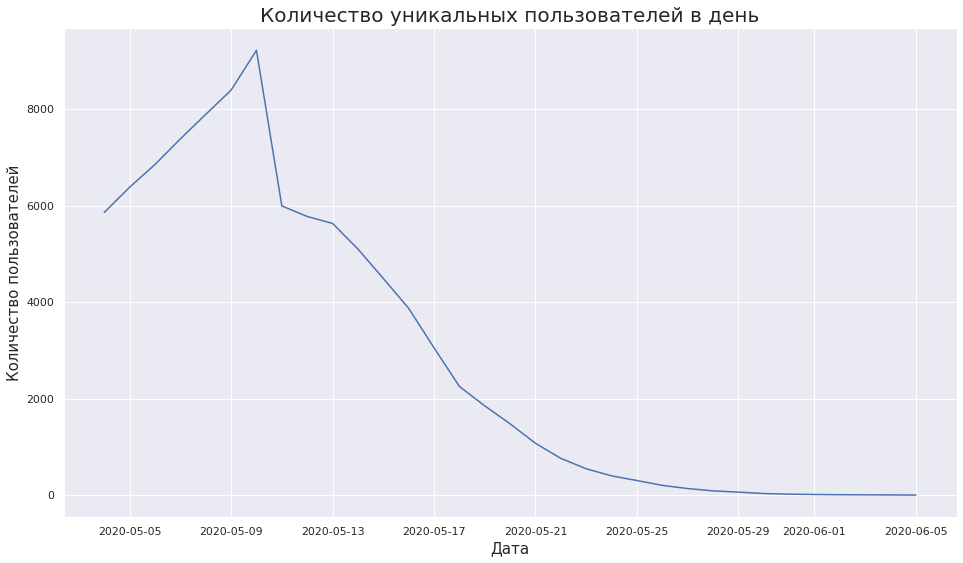

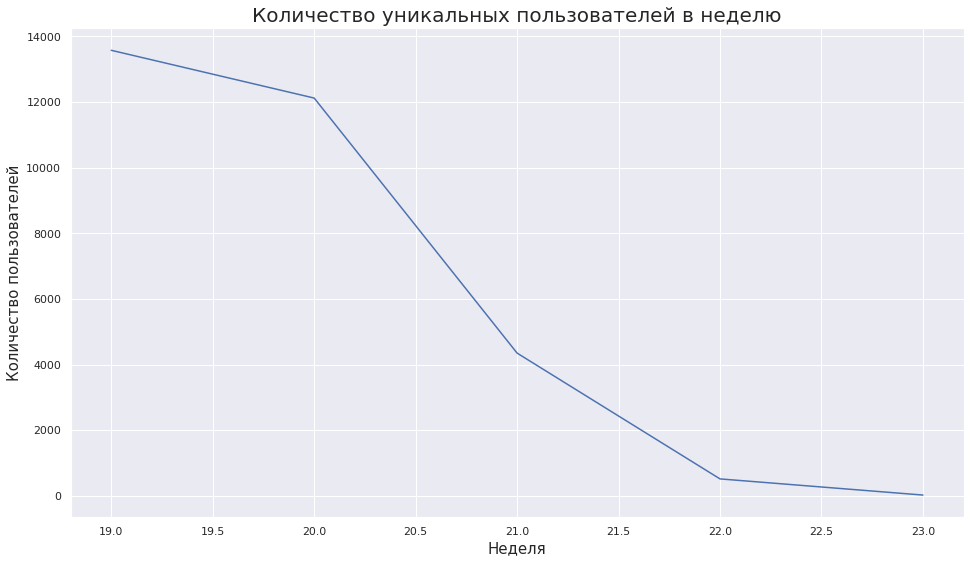

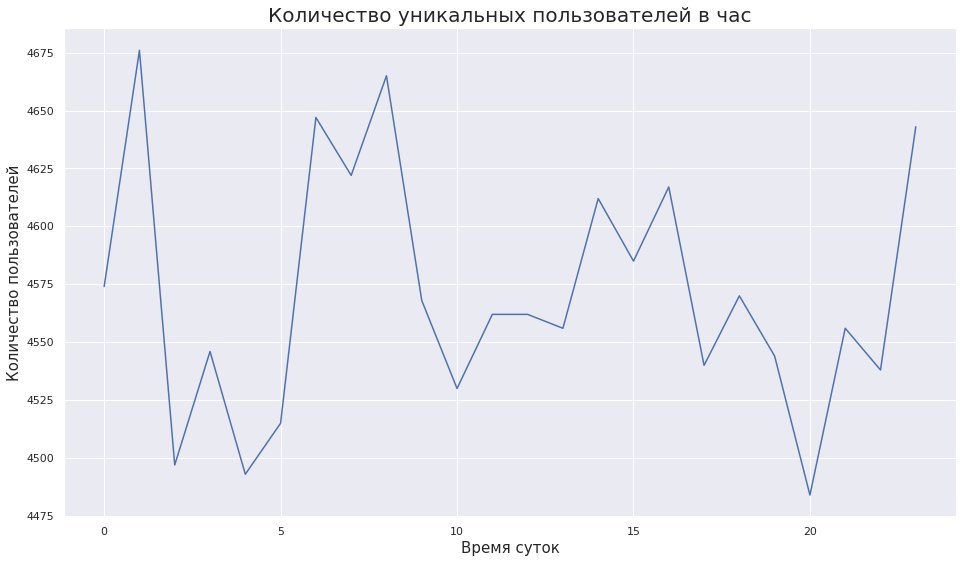

In [14]:
sns.set_theme()

lineplot(dau,
         dau.index,
         'user_nunique',
         "Количество уникальных пользователей в день", 
         "Дата",
         "Количество пользователей")

lineplot(wau,
         wau.index,
         'user_nunique',
         "Количество уникальных пользователей в неделю", 
         "Неделя",
         "Количество пользователей")

lineplot(users_per_hour,
         users_per_hour.index,
         'user_nunique',
         "Количество уникальных пользователей в час", 
         "Время суток",
         "Количество пользователей")

По графикам `dau` и `wau` видно, что количество пользователей стремительно падает. Но это нормально, ведь мы анализируем активность  тестовой когорты на первом уровне игры. Логично, что игроки проходят уровень и идут дальше. Из графиков за неделю и за день видно, что прохождение 1го уровня занимает у большинства пользователей от 1 до 2 недель. По графику суточной динамики можно сказать, что пользователи наиболее активны с 12 до 1 ночи и с 6 до 8 утра, наименее активны с 2 до 5 утра и в 8 вечера.

### Количество событий в день

Посчитаем, сколько событий пользватели совершают в день:

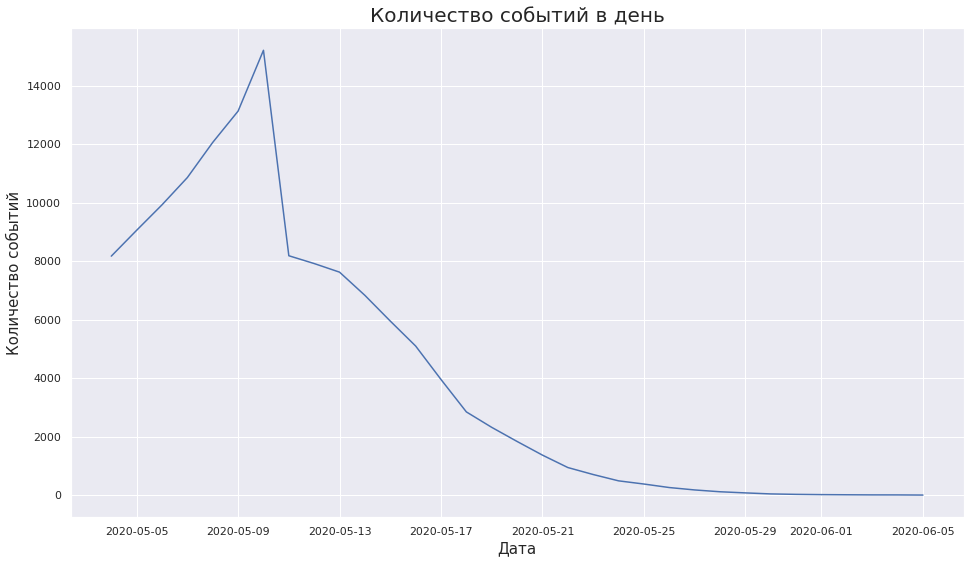

In [15]:
event_per_date = game_actions.groupby('event_date').agg({'event':'count'}).rename(columns={'event':'event_count'})

lineplot(event_per_date,
         event_per_date.index,
         'event_count',
         "Количество событий в день", 
         "Дата",
         "Количество событий")

Количество событий убывает пропорционально количеству пользователей. Посчитаем соотношение количества событий к количеству пользователей в день.

Посчитаем, сколько событий в среднем приходится на одного пользователя:

In [16]:
event_user_ratio = event_per_date.join(dau)
event_user_ratio['event_per_user'] = event_user_ratio['event_count'] / event_user_ratio['user_nunique']
event_user_ratio.head()

,event_count,user_nunique,event_per_user
event_date,,,
2020-05-04,8171,5860,1.394369
2020-05-05,9055,6382,1.418834
2020-05-06,9925,6854,1.448060
2020-05-07,10858,7384,1.470477
2020-05-08,12059,7891,1.528197


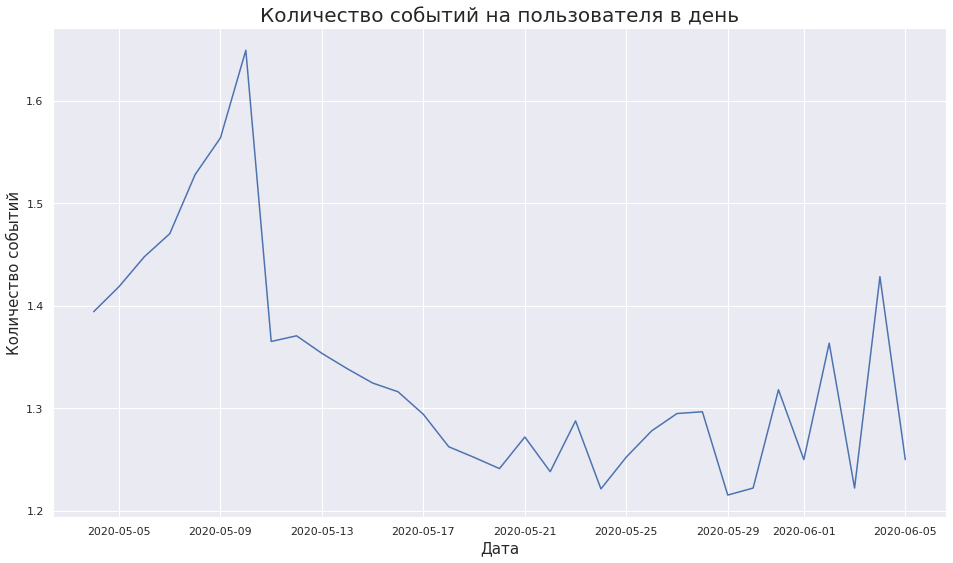

In [17]:
lineplot(event_user_ratio,
         event_user_ratio.index,
         'event_per_user',
         "Количество событий на пользователя в день", 
         "Дата",
         "Количество событий")

Видим, что колебания небольшие, в среднем пользователи совершают от 1 до 2 событий в день как в начале так и в конце первого уровня.

### Анализ источников привлечения пользователей

Сгруппируем данные по источникам привлечения пользователей, посчитаем общую стоимость привлечения для каждого источника и количество пользователей, пришедших из него. Вычислим среднюю стоимость привлечения одного пользователя для каждого источника.

In [18]:
source = ad_costs.groupby('source').agg({'cost':'sum'}).join(user_source.groupby('source').agg({'user_id':'nunique'}))
source['cost_per_user'] = source['cost'] / source['user_id']
source

,cost,user_id,cost_per_user
source,,,
facebook_ads,2140.904643,2726,0.785365
instagram_new_adverts,2161.441691,3347,0.645785
yandex_direct,2233.111449,4817,0.463590
youtube_channel_reklama,1068.119204,2686,0.397662


Построим диаграмму количества прользователей для разных источников.

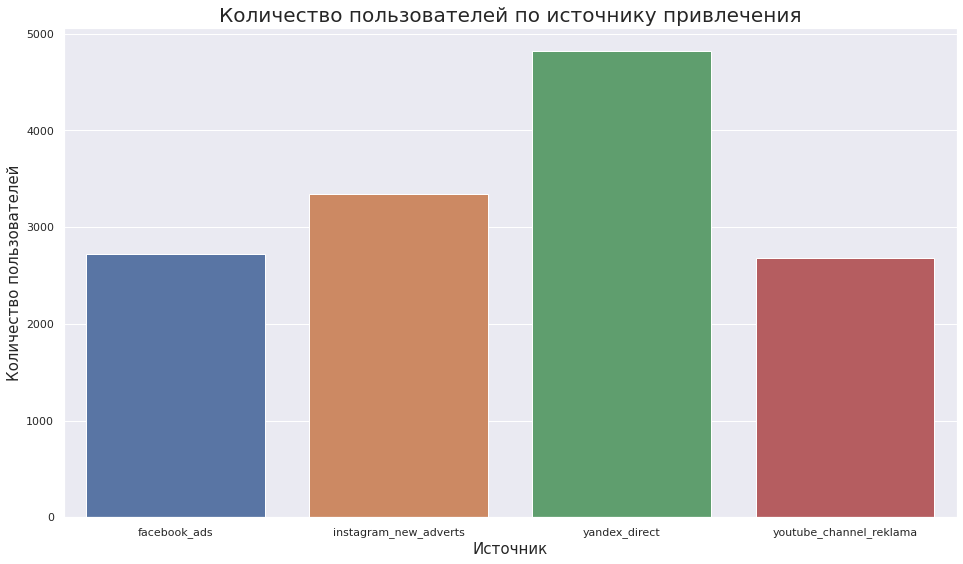

In [19]:
plt.figure(figsize=(16,9))
sns.barplot(data=source,x=source.index,y='user_id')
plt.title("Количество пользователей по источнику привлечения",fontsize=20)
plt.xlabel("Источник",fontsize=15)
plt.ylabel("Количество пользователей",fontsize=15)
plt.show()

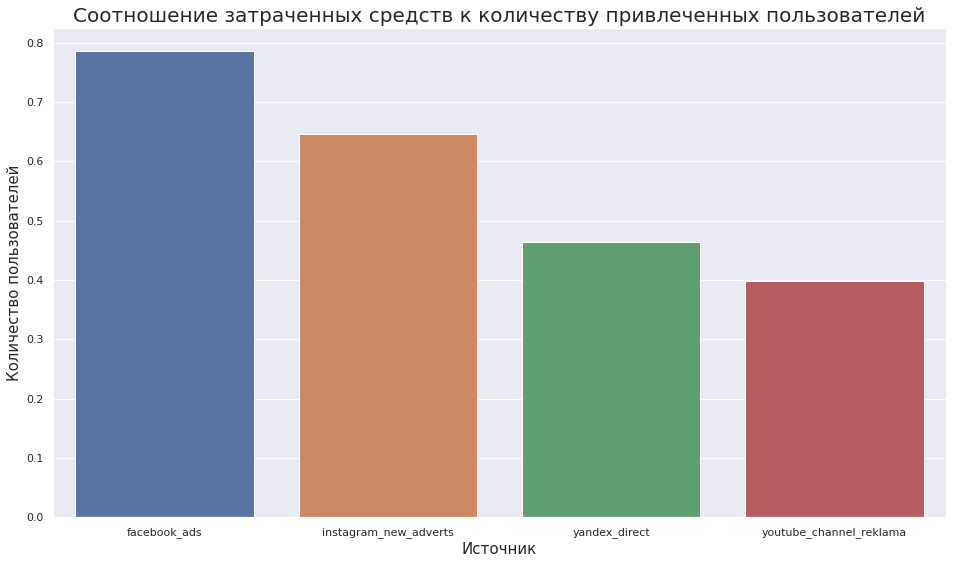

In [20]:
plt.figure(figsize=(16,9))
sns.barplot(data=source,x=source.index,y='cost_per_user')
plt.title("Соотношение затраченных средств к количеству привлеченных пользователей",fontsize=20)
plt.xlabel("Источник",fontsize=15)
plt.ylabel("Количество пользователей",fontsize=15)
plt.show()

Самые выгодные источники - `youtube` и `Яндекс.Директ` - для них средняя стоимость привлечения пользователя самая низкая. Наименнее выгодный источник - `facebook`, реклама в нем самая дорогая, при этом количество привлеченных пользователей почти такое же, как с `youtube`.

In [21]:
date_cost = ad_costs.groupby(['day','source'],as_index=False).agg({'cost':'sum'})
date_cost.head()

,day,source,cost
0,2020-05-03,facebook_ads,935.882786
1,2020-05-03,instagram_new_adverts,943.204717
2,2020-05-03,yandex_direct,969.139394
3,2020-05-03,youtube_channel_reklama,454.224943
4,2020-05-04,facebook_ads,548.354480


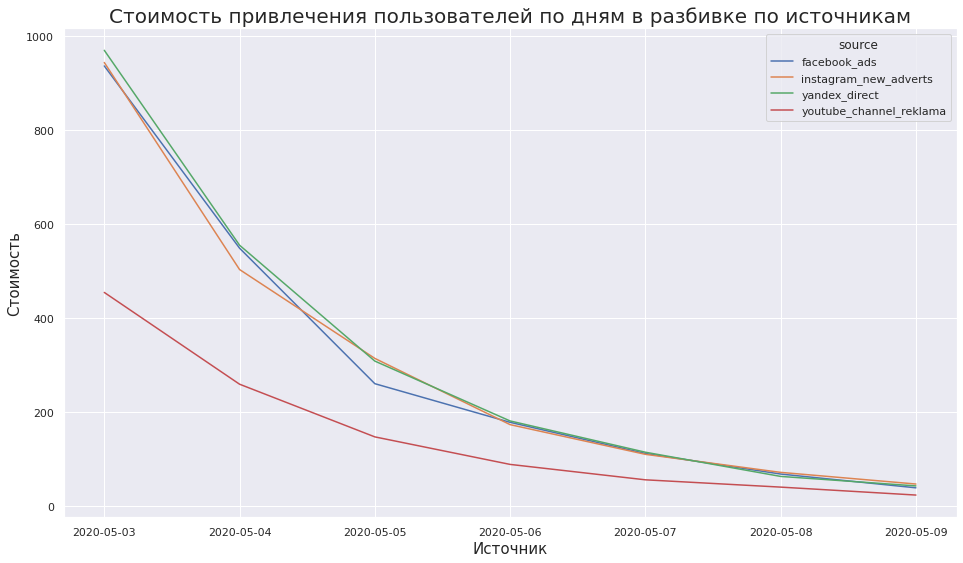

In [22]:
plt.figure(figsize=(16,9))
sns.lineplot(data=date_cost,x='day',y='cost',hue='source')
plt.title("Стоимость привлечения пользователей по дням в разбивке по источникам",fontsize=20)
plt.xlabel("Источник",fontsize=15)
plt.ylabel("Стоимость",fontsize=15)
plt.show()

Самые большие затраты на рекламу были 3 мая (эту рекламу показывали 4го), дальше затраты постепенно убывают.

Мы выяснили, что самые выгодные рекламные источники `youtube` и `Яндекс.Директ`, стоимость привлечения одного нового пользователя через них самая низкая, при этом `youtube` и `Facebook` привлекают одинаковое количество пользователей, но реклама в `Facebook` стоит значительно дороже. Имеет смысл рассмотреть вопрос перераспределения рекламных средств. 

### Анализ событий

Сгруппируем данные по типу события и дате и посчитаем количество событий.

In [23]:
event_per_date = game_actions.groupby(['event','event_date'],as_index=False).agg({'user_id':'count'})
event_per_date.head()

,event,event_date,user_id
0,building,2020-05-04,8170
1,building,2020-05-05,9052
2,building,2020-05-06,9921
3,building,2020-05-07,10847
4,building,2020-05-08,12030


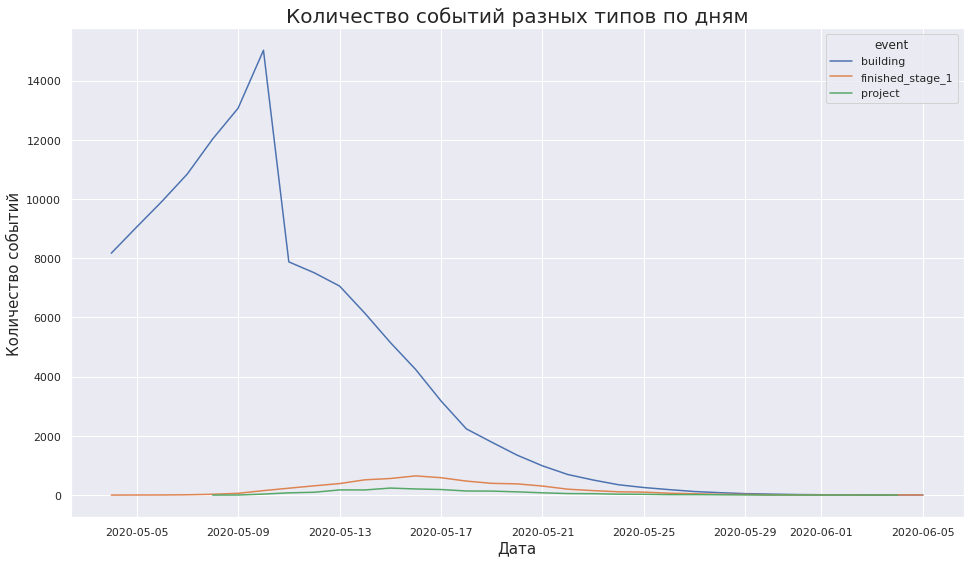

In [24]:
plt.figure(figsize=(16,9))
sns.lineplot(data=event_per_date, x='event_date', y='user_id',hue='event')
plt.title("Количество событий разных типов по дням",fontsize=20)
plt.xlabel("Дата",fontsize=15)
plt.ylabel("Количество событий",fontsize=15)
plt.show()

Видим, что подавляющее большинство событий - постройка зданий. Посмотрим, какие именно объекты пользователи предпочитают строить:

In [25]:
building = game_actions.query(
    'event == "building"').groupby('building_type').agg(
    {'event_date':'count','user_id':'nunique'}).rename(
    columns={'event_date':'building_count','user_id':'user_count'}).sort_values(
    by='building_count',ascending=False)

building['building_per_user'] = building['building_count'] / building['user_count']
building

,building_count,user_count,building_per_user
building_type,,,
spaceport,59325,13231,4.483788
assembly_shop,54494,13576,4.013995
research_center,14137,7671,1.842915


В среднем на пользователя приходится 4 космопорта и 4 сборочных цеха и 1 исследовательский центр.

Узнаем, есть ли пользователи, которые не строили здания вообще.

In [26]:
game_actions.query('event == "building"')['user_id'].nunique() - game_actions['user_id'].nunique()

0

Таких пользователей нет. Значит, вне зависимости от стратегии прохождения каждый пользователь построил хотя бы одно здание.

Сгруппируем данные по пользователям и посмотрим, сколько зданий построил каждый пользователь.

In [27]:
building_count = game_actions.query('event == "building"').groupby('user_id').agg(
    {'event':'count'}).sort_values(by='event',ascending=False)
building_count

,event
user_id,
a5add3ce-1ac4-4b97-aba0-f040efc4c1b0,20
a2f85d5e-5a53-43ee-9d41-9e1def085562,20
bf542075-e3a2-4e79-82d8-3838e86d2a25,20
1cb5b622-be18-488e-b699-6136a57eb470,20
d6aca06a-cd75-4cd8-b8cd-240a3c163884,20
...,...
7ac32352-627b-421c-9319-b77a37947625,1
531a93d9-f57d-4b60-8eec-ee709ff7c67c,1
e17fd642-a43d-41d4-86a8-c81c6107f9cc,1


Пользователи строят минимум 1 здание и максимум 20. Вероятно, 20 - максимальное количество зданий, которые пользователи могут построить на первом уровне. Построим гистограмму и посмотрим распределение.

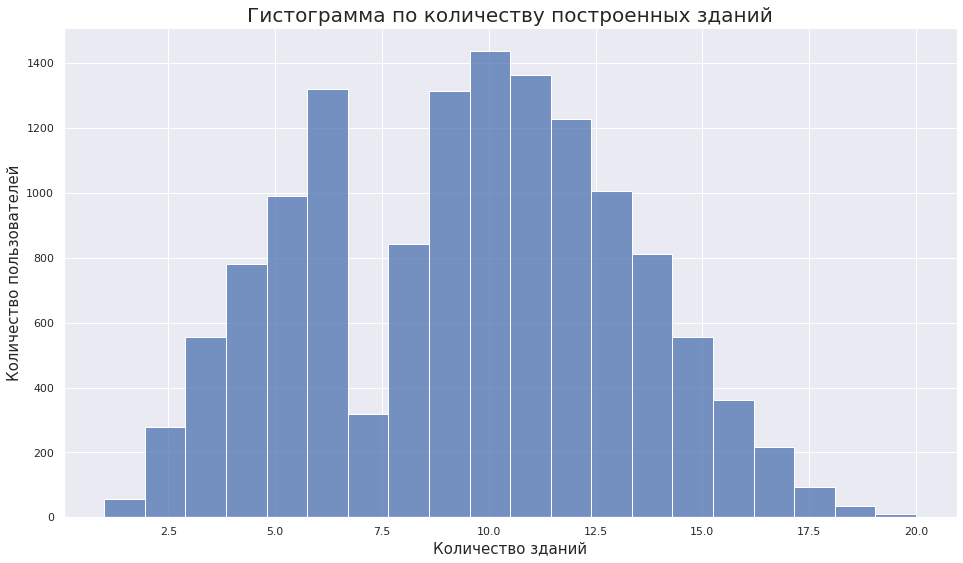

In [28]:
plt.figure(figsize=(16,9))
sns.histplot(data=building_count,x='event',bins=20)
plt.title("Гистограмма по количеству построенных зданий",fontsize=20)
plt.xlabel("Количество зданий",fontsize=15)
plt.ylabel("Количество пользователей",fontsize=15)
plt.show()

Распределение близко к нормальному, однако в районе 7-8 зданий заметна значительная просадка. Вероятно, после 6 построенных зданий многие пользователи переходят на следующий уровень или покидуют игру. Предположительно, есть 2 группы пользователей - те кто проходит игру с минимальными усилиями, строят 6 зданий и завершают уровень, и те, кто пытается выжать из первого уровня максимум.

### Анализ стратегий прохождения первого уровня

* **Процент игроков, прошедших уровень**

По нашим данным есть 2 стратегии прохождения первого уровня:
* победа над врагом
* завершение проекта

Также возможно, есть пользователи, которые не прошли первый уровень, сначала изучим их:

In [29]:
# для каждого пользователя найдем последнее событие
last_event = game_actions.groupby('user_id').agg({'event':'last'})
last_event.head()

,event
user_id,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,building
00151b4f-ba38-44a8-a650-d7cf130a0105,building
001aaea6-3d14-43f1-8ca8-7f48820f17aa,building
001d39dc-366c-4021-9604-6a3b9ff01e25,finished_stage_1
002f508f-67b6-479f-814b-b05f00d4e995,building


In [30]:
win_procent = round(last_event[last_event['event'] == 'finished_stage_1'].count() / last_event.count() * 100,2)
print('Процент игроков, прошедших уровень {}'.format(win_procent))

Процент игроков, прошедших уровень event    42.85
dtype: float64


Всего 43% игроков из тестовой когорты завершили первый уровень.

In [31]:
# список с пользователями, завершившими первый уровень
finished_list = last_event.query('event == "finished_stage_1"').index

In [32]:
# список с пользователями, завершившими первый уровень через проект
project_finish = game_actions.query('project_type == "satellite_orbital_assembly"')['user_id'].unique()

* **Пользовательские профили и проверка гипотезы**

Составим пользовательские профили, в которых будут даты первого и последнего события, совершенного пользователем, источник, факт завершения первого уровня и тип завершения (проект или победа над врагом). Будем считать, что если пользователь не завершил проект, но при этом завершил уровень, то он победил врага.

In [33]:
profiles = game_actions.groupby('user_id').agg({
    'event_datetime':['first','last']}).droplevel(0,1).merge(user_source,on='user_id',how='left')
profiles['finished'] = profiles['user_id'].isin(finished_list)
profiles['project_finish'] = profiles['user_id'].isin(project_finish)
profiles['timedelta'] = (profiles['last'] - profiles['first']).dt.days
profiles.head()

,user_id,first,last,source,finished,project_finish,timedelta
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-20 11:26:06,facebook_ads,False,False,14
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-18 10:46:52,yandex_direct,False,False,12
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-14 09:21:27,youtube_channel_reklama,False,False,8
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,instagram_new_adverts,True,False,6
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-22 02:46:45,facebook_ads,False,False,16


Проверим гипотезу о том, что время прохождения уровня через завершение проекта и через победу над врагом одинаковое.

Но: Среднее время прохождения уровня через завершение проекта и через победу над врагом одинаковое.

Н1: Среднее время прохождения уровня через завершение проекта и через победу над врагом различно.

In [34]:
# критический уровень статистической значимости
alpha = 0.05

# проверка гипотезы о равенстве двух независимых совокупностей
results = st.ttest_ind(profiles.query('project_finish == True and finished == True')['timedelta'],
                       profiles.query('finished == True and project_finish == False')['timedelta']) 
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.8882835392369192e-97
Отвергаем нулевую гипотезу


Значение p-значение меньше уровня значимости, значит есть основания отвергнуть нулевую гипотезу, и принять что время прохожения уровня двумя стратегиями отличается.

* **Сколько времени пользователи тратят на игру**

Сравним время, проведенное в игре среди пользователей, прошедших и не прошедших уровень, и среди завершивших и не завершивших проект.

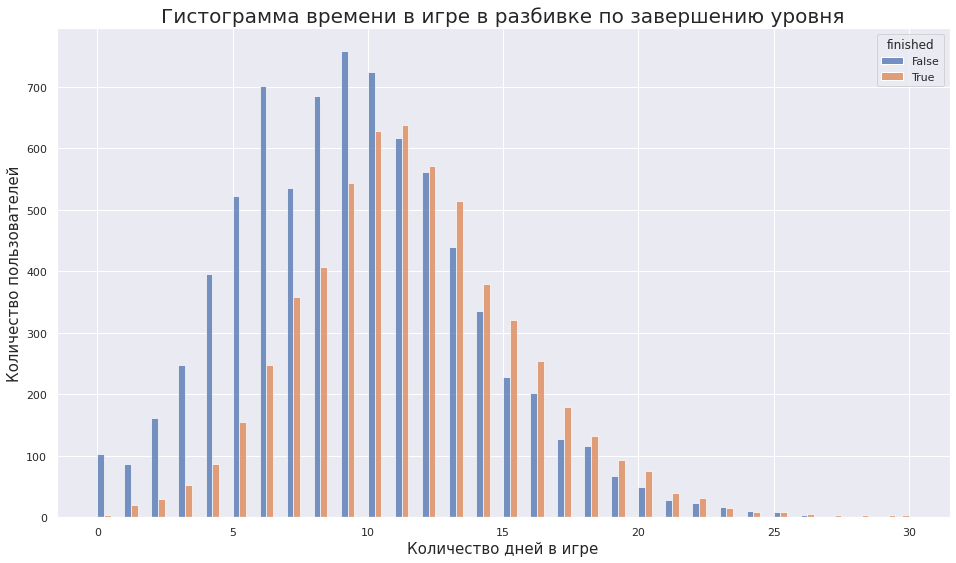

In [35]:
plt.figure(figsize=(16,9))
sns.histplot(data=profiles,x='timedelta',hue='finished',multiple='dodge')
plt.title("Гистограмма времени в игре в разбивке по завершению уровня",fontsize=20)
plt.xlabel("Количество дней в игре",fontsize=15)
plt.ylabel("Количество пользователей",fontsize=15)
plt.show()

Пик для игроков, не прошедших уровень, приходится на 9 день, а для прошедших - на 11.

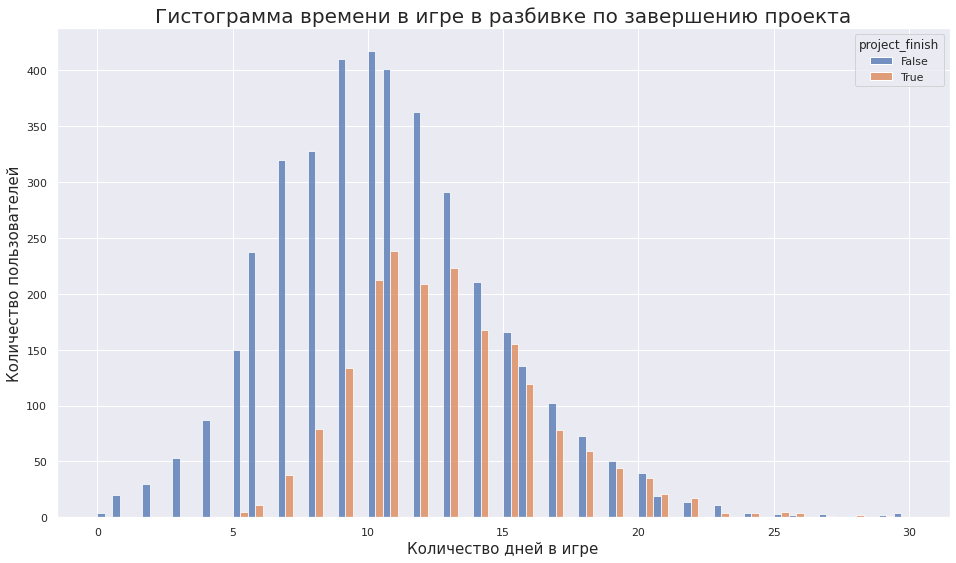

In [36]:
plt.figure(figsize=(16,9))
sns.histplot(data=profiles.query('finished == True'),x='timedelta',hue='project_finish',multiple='dodge')
plt.title("Гистограмма времени в игре в разбивке по завершению проекта",fontsize=20)
plt.xlabel("Количество дней в игре",fontsize=15)
plt.ylabel("Количество пользователей",fontsize=15)
plt.show()

Видим, что гистограмма для пользователей, завершивших уровень через проект сдвинута вправо - они тратят больше времени на игру. Посчитаем медианные значения для тех и других:

In [37]:
print('Медианное количество дней в игре для завершивших проект: {}'.format(
    profiles.query('project_finish == True and finished == True')['timedelta'].median()))

print("Медианное количество дней в игре для победивших врага: {}".format(
    profiles.query('finished == True and project_finish == False')['timedelta'].median()))

Медианное количество дней в игре для завершивших проект: 13.0
Медианное количество дней в игре для победивших врага: 10.0


Для завершения проекта действительно требруется больше времени - в среднем 13 дней, а чтобы победить врага - 10 дней.

* **Какие объекты строят пользователи, придерживающиеся разных стратегий**

Посмотрим сколько объектов строят пользователи в зависимости от выбранной стратегии:

In [38]:
building_count = building_count.reset_index().merge(profiles[['user_id','project_finish','finished']],on='user_id',how='left')
building_count.head()

,user_id,event,project_finish,finished
0,a5add3ce-1ac4-4b97-aba0-f040efc4c1b0,20,False,False
1,a2f85d5e-5a53-43ee-9d41-9e1def085562,20,False,False
2,bf542075-e3a2-4e79-82d8-3838e86d2a25,20,True,True
3,1cb5b622-be18-488e-b699-6136a57eb470,20,False,False
4,d6aca06a-cd75-4cd8-b8cd-240a3c163884,20,True,True


Проверим гипотезу о том, что игроки прошедшие уровень через проект и через победу над врагом строят в среднем одинаковое количество зданий.

Но: Среднее количество построек у завершивших проект и у победивших врага одинаковое.

Н1: Среднее количество построек у завершивших проект и у победивших врага отличается.

In [39]:
# критический уровень статистической значимости
alpha = 0.05

# проверка гипотезы о равенстве двух независимых совокупностей
results = st.ttest_ind(building_count.query('project_finish == True and finished == True')['event'],
                       building_count.query('finished == True and project_finish == False')['event']) 
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.0
Отвергаем нулевую гипотезу


Вероятность случайным образом получить результат, при котором среднее количество построек у обеих групп будет одинаковым равна нулю. Значит отвергаем нулевую гипотезу.

In [40]:
building_project = building_count.groupby('project_finish').agg({'event':'sum','user_id':'nunique'})
building_project['building_per_user'] = round(building_project['event'] / building_project['user_id'],0)
building_project

,event,user_id,building_per_user
project_finish,,,
False,104355,11710,9.0
True,23601,1866,13.0


Пользователи завершившие проект, построили в среднем 13 объектов, а незавершившие - всего 9.

Добавим в пользовательские профили столбец с типом стратегии: проект, победа над врагом, либо не прошёл уровень. Для этого напишем функцию, распределяющую пользователей по категориям.

In [41]:
def strategy_category(row):
    if row['finished'] == True and row['project_finish'] == True:
        return 'проект'
    if row['finished'] == True and row['project_finish'] == False:
        return 'победа над врагом'
    else: return 'не прошёл'

In [42]:
profiles['strategy'] = profiles.apply(strategy_category,axis=1)
profiles.head()

,user_id,first,last,source,finished,project_finish,timedelta,strategy
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-20 11:26:06,facebook_ads,False,False,14,не прошёл
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-18 10:46:52,yandex_direct,False,False,12,не прошёл
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-14 09:21:27,youtube_channel_reklama,False,False,8,не прошёл
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,instagram_new_adverts,True,False,6,победа над врагом
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-22 02:46:45,facebook_ads,False,False,16,не прошёл


Добавим информацию о страгии в таблицу game_actions.

In [43]:
game_actions = game_actions.merge(profiles[['user_id','strategy']], on='user_id',how='left')
game_actions.head()

,event_datetime,event,building_type,user_id,project_type,event_date,event_hour,event_week,strategy
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,0,19,не прошёл
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,0,19,проект
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04,0,19,победа над врагом
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04,0,19,не прошёл
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04,0,19,победа над врагом


In [44]:
strategy_count = profiles.groupby('strategy').agg({'user_id':'nunique'})
strategy_count['sum'] = strategy_count['user_id'].sum()
strategy_count['user_%'] = round(strategy_count['user_id'] / strategy_count['sum'] * 100,2)
strategy_count

,user_id,sum,user_%
strategy,,,
не прошёл,7759,13576,57.15
победа над врагом,3951,13576,29.10
проект,1866,13576,13.74


57% игроков не завершили 1 уровень, 29% завершили уровень через победу над врагом, 14% - через завершение проекта.

Узнаем, какие объекты предпочитают строить приверженцы той или иной стратегии. Сгруппируем данные по стратегии и типу постройки, посчитаем количество уникальных пользователей.

In [45]:
strategy_building = game_actions.groupby(['strategy','building_type']).agg({'user_id':'nunique'}).reset_index()
strategy_building

,strategy,building_type,user_id
0,не прошёл,assembly_shop,7759
1,не прошёл,research_center,3463
2,не прошёл,spaceport,7471
3,победа над врагом,assembly_shop,3951
4,победа над врагом,research_center,2342
5,победа над врагом,spaceport,3894
6,проект,assembly_shop,1866
7,проект,research_center,1866
8,проект,spaceport,1866


Добавим в таблицу общее число игроков, построивших здания определенного типа, чтобы посчитать процентное соотношение.

In [46]:
all_building = game_actions.groupby('strategy').agg({'user_id':'nunique'}).reset_index().rename(columns={'user_id':'all_users'})
strategy_building = strategy_building.merge(all_building, on='strategy',how='left')
strategy_building['building_%'] = round(strategy_building['user_id'] / strategy_building['all_users'] * 100,1)
strategy_building

,strategy,building_type,user_id,all_users,building_%
0,не прошёл,assembly_shop,7759,7759,100.0
1,не прошёл,research_center,3463,7759,44.6
2,не прошёл,spaceport,7471,7759,96.3
3,победа над врагом,assembly_shop,3951,3951,100.0
4,победа над врагом,research_center,2342,3951,59.3
5,победа над врагом,spaceport,3894,3951,98.6
6,проект,assembly_shop,1866,1866,100.0
7,проект,research_center,1866,1866,100.0
8,проект,spaceport,1866,1866,100.0


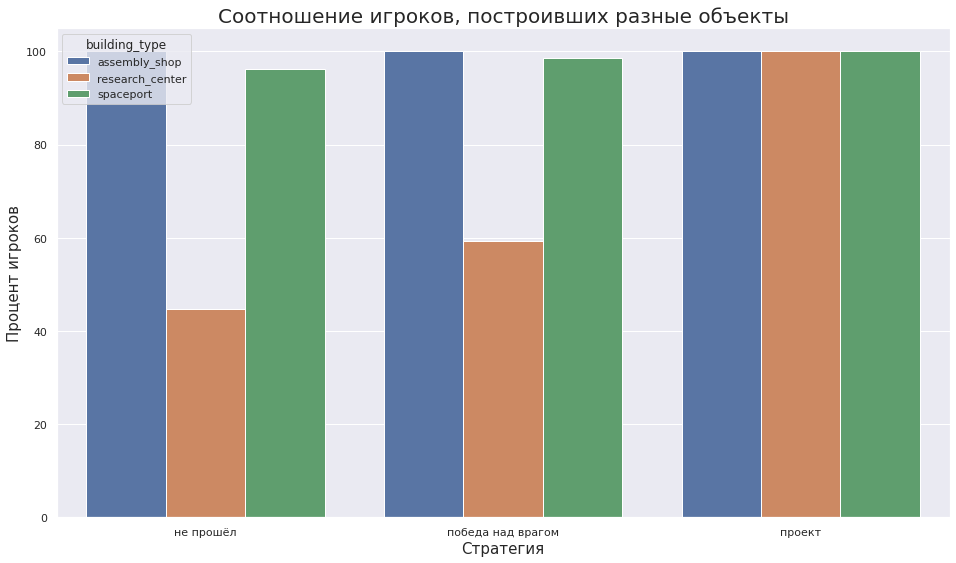

In [47]:
plt.figure(figsize=(16,9))
sns.barplot(data = strategy_building, x='strategy',y='building_%',hue='building_type')
plt.title("Соотношение игроков, построивших разные объекты",fontsize=20)
plt.xlabel("Стратегия",fontsize=15)
plt.ylabel("Процент игроков",fontsize=15)
plt.show()

Все игроки построили сборочный цех - скорее всего это обязательное действие. Все игроки завершившие проект построили все типы зданий, скорее всего это необходимо для проекта. Почти все игроки, завершившие уровень через победу над врагом, построили космопорты - видимо они нужны для сражений, а вот исследовательские центры построило только 60% из них, видимо при такой стратегии они не особо нужны.

### Расчет Retention Rate

Интересно будет расчитать Retention Rate и узнать, как долго пользователи остаются вовлеченными в игру и возвращаются.

Добавим в исходную таблицу с событиями game_actions столбец с временем первого события из таблицы profiles. Будем считать это время временем первой сессии.

In [48]:
# объединим game_actions со столбцом first из таблицы profiles
result_raw = game_actions.merge(profiles[['user_id','first']],on='user_id',how='left').rename(columns={'first':'first_visit'})
result_raw['first_visit_date'] = result_raw['first_visit'].dt.date

In [49]:
# вычисляем лайфтайм для каждого события в днях
result_raw['lifetime'] = (result_raw['event_datetime'] - result_raw['first_visit']).dt.days
result_raw.head()

,event_datetime,event,building_type,user_id,project_type,event_date,event_hour,event_week,strategy,first_visit,first_visit_date,lifetime
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,0,19,не прошёл,2020-05-04 00:00:01,2020-05-04,0
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,0,19,проект,2020-05-04 00:00:03,2020-05-04,0
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04,0,19,победа над врагом,2020-05-04 00:00:16,2020-05-04,0
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04,0,19,не прошёл,2020-05-04 00:00:16,2020-05-04,0
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04,0,19,победа над врагом,2020-05-04 00:00:35,2020-05-04,0


In [50]:
# формируем таблицу удержания
result_grouped = result_raw.pivot_table(index='first_visit_date',columns='lifetime', values='user_id', aggfunc='nunique')
result_grouped

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
first_visit_date,,,,,,,,,,,,,,,,,,,,,
2020-05-04,5860.0,3135.0,3303.0,3469.0,3642.0,3938.0,3656.0,2588.0,2479.0,2240.0,...,54.0,39.0,26.0,18.0,8.0,6.0,4.0,1.0,2.0,3.0
2020-05-05,3361.0,1818.0,1948.0,2081.0,2215.0,2010.0,1618.0,1395.0,1320.0,1225.0,...,31.0,24.0,11.0,9.0,7.0,2.0,3.0,1.0,NaN,NaN
2020-05-06,1847.0,961.0,1053.0,1201.0,1059.0,800.0,841.0,710.0,651.0,609.0,...,17.0,8.0,6.0,3.0,3.0,2.0,2.0,1.0,2.0,1.0
2020-05-07,1109.0,597.0,644.0,565.0,421.0,474.0,540.0,359.0,354.0,307.0,...,11.0,10.0,8.0,6.0,3.0,3.0,2.0,3.0,2.0,NaN
2020-05-08,688.0,352.0,331.0,253.0,259.0,309.0,310.0,191.0,198.0,198.0,...,5.0,3.0,4.0,1.0,NaN,2.0,NaN,NaN,NaN,NaN
2020-05-09,440.0,177.0,143.0,164.0,195.0,179.0,199.0,127.0,104.0,105.0,...,4.0,3.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2020-05-10,271.0,59.0,99.0,97.0,105.0,103.0,131.0,60.0,51.0,66.0,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# вычисляем размеры когорт

cohort_sizes = (
    result_raw.groupby('first_visit_date')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

cohort_sizes

,cohort_size
first_visit_date,
2020-05-04,5860
2020-05-05,3361
2020-05-06,1847
2020-05-07,1109
2020-05-08,688
2020-05-09,440
2020-05-10,271


In [52]:
# объединяем размеры когорт и таблицу удержания

result_grouped = cohort_sizes.merge(
    result_grouped, on='first_visit_date', how='left'
).fillna(0)

# делим данные таблицы удержания на размеры когорт

result_grouped = result_grouped.div(
    result_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size'])

result_grouped

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
first_visit_date,,,,,,,,,,,,,,,,,,,,,
2020-05-04,1.0,0.534983,0.563652,0.591980,0.621502,0.672014,0.623891,0.441638,0.423038,0.382253,...,0.009215,0.006655,0.004437,0.003072,0.001365,0.001024,0.000683,0.000171,0.000341,0.000512
2020-05-05,1.0,0.540910,0.579589,0.619161,0.659030,0.598036,0.481404,0.415055,0.392740,0.364475,...,0.009223,0.007141,0.003273,0.002678,0.002083,0.000595,0.000893,0.000298,0.000000,0.000000
2020-05-06,1.0,0.520303,0.570114,0.650244,0.573362,0.433135,0.455333,0.384407,0.352463,0.329724,...,0.009204,0.004331,0.003249,0.001624,0.001624,0.001083,0.001083,0.000541,0.001083,0.000541
2020-05-07,1.0,0.538323,0.580703,0.509468,0.379621,0.427412,0.486925,0.323715,0.319206,0.276826,...,0.009919,0.009017,0.007214,0.005410,0.002705,0.002705,0.001803,0.002705,0.001803,0.000000
2020-05-08,1.0,0.511628,0.481105,0.367733,0.376453,0.449128,0.450581,0.277616,0.287791,0.287791,...,0.007267,0.004360,0.005814,0.001453,0.000000,0.002907,0.000000,0.000000,0.000000,0.000000
2020-05-09,1.0,0.402273,0.325000,0.372727,0.443182,0.406818,0.452273,0.288636,0.236364,0.238636,...,0.009091,0.006818,0.002273,0.002273,0.002273,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-10,1.0,0.217712,0.365314,0.357934,0.387454,0.380074,0.483395,0.221402,0.188192,0.243542,...,0.003690,0.003690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


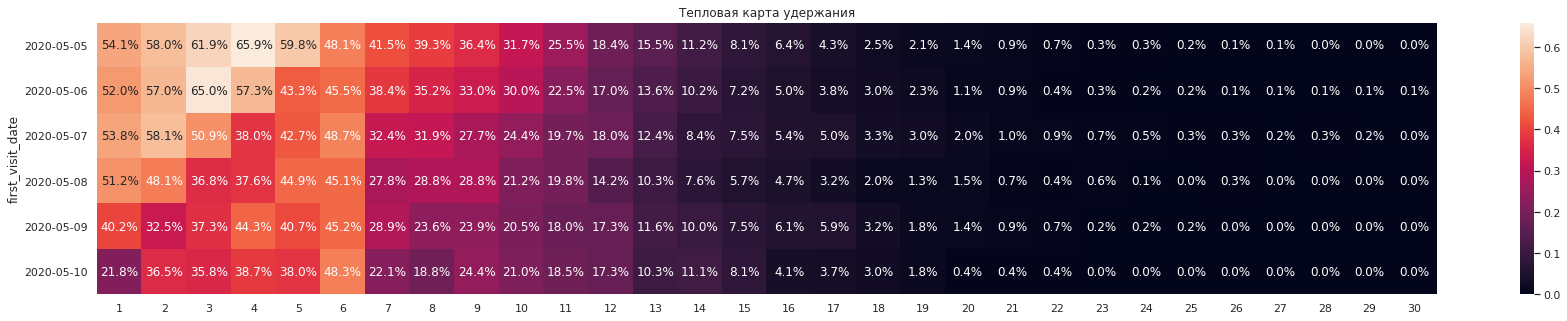

In [53]:
# строим тепловую карту Retention Rate
plt.figure(figsize=(30,5))
sns.heatmap(result_grouped.drop(columns=[0])[1:14], annot=True, fmt='.1%')
plt.title('Тепловая карта удержания')
plt.show()

Видим, что интерес к игре максимален в течение первой недели, показатель Retention Rate больше 40%, далее пользователи постепенно начинают отваливаться - скорее всего переходят на новый уровень. К сожалению, у нас нет данных, чтобы узнать, какая доля пользователей продолжила играть на следующих уровнях, а какая отвалилась.
Но можно сказать, что игра способна удержать интерес пользователей, раз они продолжают играть в течение 7-10 дней.

Построим кривые удержания:

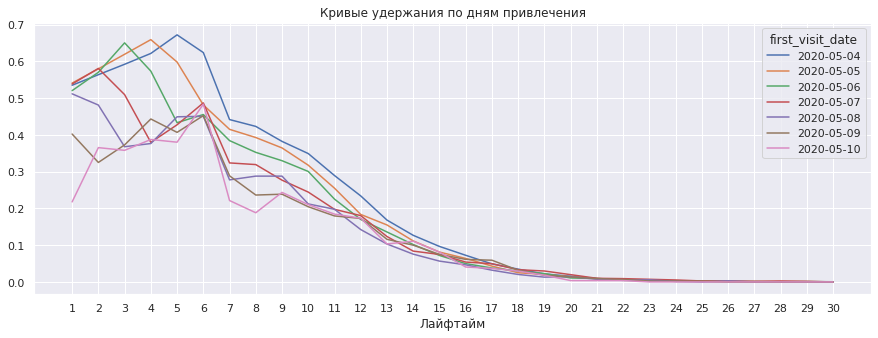

In [54]:
# строим кривые удержания

report = result_grouped.drop(columns = [0])

report.T.plot(
    grid=True,
    xticks=list(report.columns.values),
    figsize=(15, 5),
)
plt.xlabel('Лайфтайм')
plt.title('Кривые удержания по дням привлечения')
plt.show()

Самый высокий коэфициент удержания у пользователей, привлеченных 4 и 5 мая, худший - 10 мая.

### Расчет конверсии

Расчитаем конверсии - сколько пользователей из каждой когорты перешло на следующий уровень игры.

In [55]:
profiles['first_dt'] = profiles['first'].dt.date

In [56]:
# считаем конверсии по дате привлечения
conversion = profiles.pivot_table(
    index='first_dt',columns='finished',values='user_id',aggfunc='nunique').reset_index().rename(
    columns={False:'not_finished',True:'finished'})

conversion['sum'] = conversion['not_finished'] + conversion['finished']
conversion['finished_%'] = round(conversion['finished'] / conversion['sum'] * 100,1)
conversion

finished,first_dt,not_finished,finished,sum,finished_%
0,2020-05-04,3190,2670,5860,45.6
1,2020-05-05,1848,1513,3361,45.0
2,2020-05-06,1076,771,1847,41.7
3,2020-05-07,697,412,1109,37.2
4,2020-05-08,453,235,688,34.2
5,2020-05-09,306,134,440,30.5
6,2020-05-10,189,82,271,30.3


Больше всего на следующий уровень перешло игроков, привлеченных 4 и 5 мая, меньше всего - 10 мая.

Посчитаем конверсии по источникам привлечения игроков.

In [57]:
# считаем конверсии по источнику привлечения
conversion_source = profiles.pivot_table(
    index='source',columns='finished',values='user_id',aggfunc='nunique').reset_index().rename(
    columns={False:'not_finished',True:'finished'})

conversion_source['sum'] = conversion_source['not_finished'] + conversion_source['finished']
conversion_source['finished_%'] = round(conversion_source['finished'] / conversion_source['sum'] * 100,1)
conversion_source

finished,source,not_finished,finished,sum,finished_%
0,facebook_ads,1576,1150,2726,42.2
1,instagram_new_adverts,1881,1466,3347,43.8
2,yandex_direct,2775,2042,4817,42.4
3,youtube_channel_reklama,1527,1159,2686,43.1


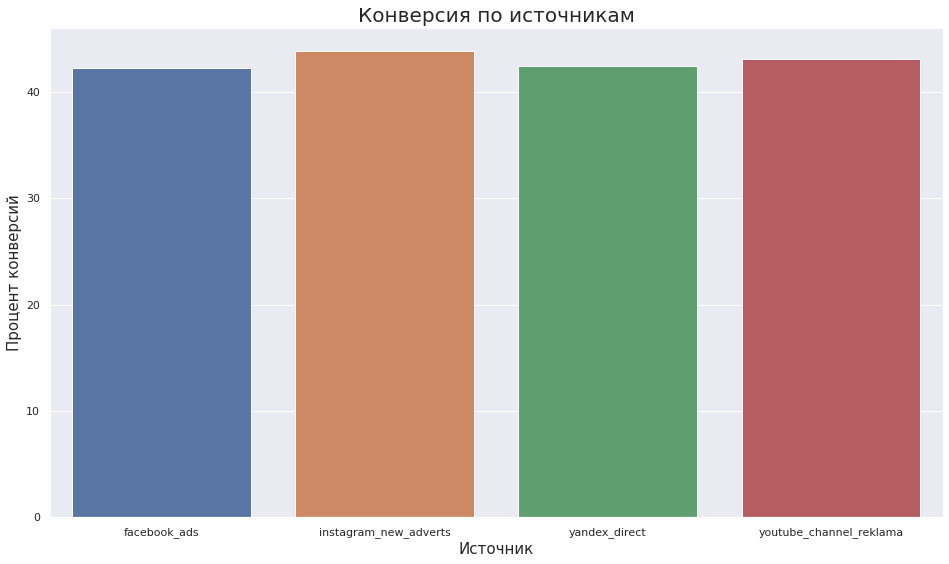

In [58]:
plt.figure(figsize=(16,9))
sns.barplot(data=conversion_source, x='source', y='finished_%')
plt.title("Конверсия по источникам",fontsize=20)
plt.xlabel("Источник",fontsize=15)
plt.ylabel("Процент конверсий",fontsize=15)
plt.show()

Пользователи, пришедшие из разных источников конвертировались примерно одинаково.

### Вывод по разделу

* В среднем игроки совершают 1-2 события в день.
* Наиболее выгодные рекламные источники Youtube и Яндекс.Директ, самый невыгодный - Facebook, количество пользователей привлеченных через него лишь немного больше, чем у Youtube, однако реклама в Facebook стоит дороже.
* Самое частое событие - строительство зданий.
* Все пользователи построили хотя бы одно здание.
* 57% игроков не завершили 1 уровень, 29% завершили уровень через победу над врагом, 14% - через завершение проекта.
* Все игроки построили сборочный цех; игроки, завершившие проект построили все типы зданий; победившие врага предпочитали строить космопорты, а не исследовательские центры
* Завершившие проект в среднем прошли уровень за 13 дней, победившие врага - за 10.
* Пользователи завершившие проект, построили в среднем 13 объектов, а незавершившие - всего 9.
* Интерес к игре максимален в течение первой недели, Retention Rate более 40%, дальше Retention Rate постепенно падает - пользователи переходят на новый уровень.
* Больше всего на следующий уровень перешло игроков, привлеченных 4 и 5 мая.
* Пользователи пришедшие из разных источник имеют одинаковое "качество" - на следующий уровень перешло 43%, пришедших из каждого источника.

## Формирование модели монетизации

Согласно модели, предложенной заказчиком, реклама будет показываться каждый раз, когда игрок завершает постройку очередного здания. За каждый просмотр рекламы пользователем мы получим 7 центов. Рассчитаем LTV, CAС и ROI для такой модели и посмотрим, будет ли она окупаться и приносить прибыль.

### Расчет LTV

Для расчёта LTV первым делом нужно добавить в таблицу result_raw, сформированную ранее, информацию о выручке. Добавим столбец revenue, в котором каждому строительству будет соотвествовать 0.07, а всем другим событиям - 0.

In [59]:
# функция для добавления revenue
def revenue_category(row):
    if row['event'] == 'building':
        return 0.07
    else:
        return 0

In [60]:
# применение функции revenue_category
result_raw['revenue'] = result_raw.apply(revenue_category,axis=1)
result_raw.head()

,event_datetime,event,building_type,user_id,project_type,event_date,event_hour,event_week,strategy,first_visit,first_visit_date,lifetime,revenue
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,0,19,не прошёл,2020-05-04 00:00:01,2020-05-04,0,0.07
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,0,19,проект,2020-05-04 00:00:03,2020-05-04,0,0.07
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04,0,19,победа над врагом,2020-05-04 00:00:16,2020-05-04,0,0.07
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04,0,19,не прошёл,2020-05-04 00:00:16,2020-05-04,0,0.07
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04,0,19,победа над врагом,2020-05-04 00:00:35,2020-05-04,0,0.07


In [61]:
# формируем треугольную таблицу выручки
result = result_raw.pivot_table(index='first_visit_date',
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

# находим сумму выручки с накоплением
result = result.fillna(0).cumsum(axis=1)

# присоединим размеры когорт, расчитаные ранее для Retention Rate
result = cohort_sizes.join(result).fillna(0)

# делим выручку на размер когорт
result = result.div(result['cohort_size'], axis=0)
result

,cohort_size,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
first_visit_date,,,,,,,,,,,,,,,,,,,,,
2020-05-04,1.0,0.120171,0.174630,0.232899,0.296401,0.365744,0.442445,0.510403,0.550623,0.587869,...,0.723258,0.723652,0.723903,0.724118,0.724189,0.724249,0.724273,0.724273,0.724285,0.724309
2020-05-05,1.0,0.122838,0.179905,0.241178,0.308179,0.380470,0.444701,0.490354,0.528218,0.562416,...,0.681068,0.681506,0.681693,0.681839,0.681964,0.682005,0.682026,0.682026,0.682026,0.682026
2020-05-06,1.0,0.121733,0.175436,0.236605,0.307060,0.367737,0.407531,0.450888,0.484959,0.515355,...,0.620146,0.620336,0.620601,0.620753,0.620828,0.620866,0.620942,0.620980,0.621018,0.621018
2020-05-07,1.0,0.118287,0.175032,0.237899,0.289720,0.323490,0.360541,0.405482,0.433697,0.460523,...,0.560252,0.560821,0.561136,0.561326,0.561452,0.561641,0.561767,0.561957,0.562020,0.562020
2020-05-08,1.0,0.113648,0.165436,0.210102,0.241541,0.273387,0.313983,0.355189,0.378794,0.404026,...,0.491323,0.491628,0.492137,0.492238,0.492238,0.492340,0.492340,0.492340,0.492340,0.492340
2020-05-09,1.0,0.113114,0.148273,0.176909,0.208409,0.245955,0.279682,0.319455,0.343318,0.362886,...,0.453727,0.454205,0.454364,0.454364,0.454364,0.454364,0.454364,0.454364,0.454364,0.454364
2020-05-10,1.0,0.098930,0.116753,0.145941,0.175904,0.207675,0.242804,0.284133,0.301697,0.318229,...,0.410443,0.410443,0.410443,0.410443,0.410443,0.410443,0.410443,0.410443,0.410443,0.410443


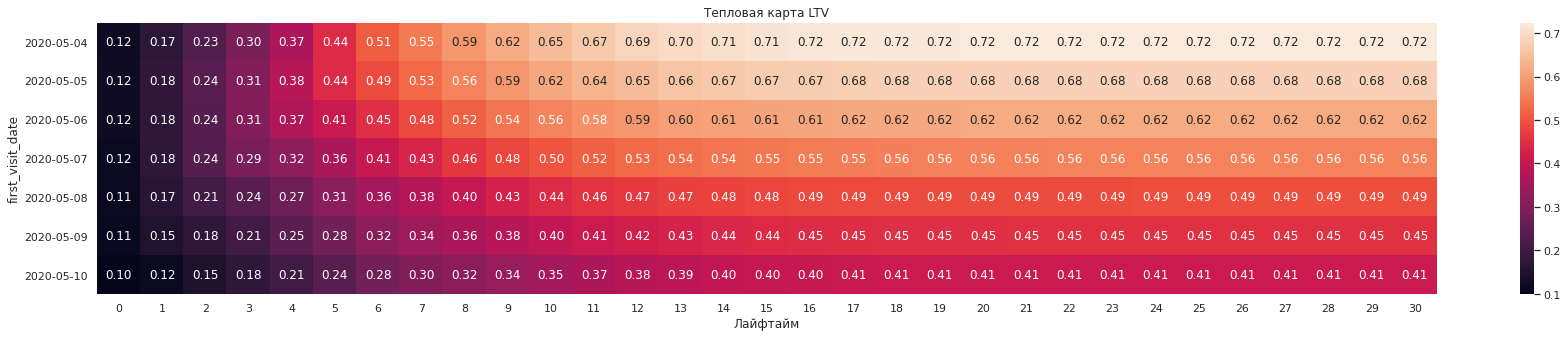

In [62]:
# построим тепловую карту
plt.figure(figsize=(30,5))
sns.heatmap(result.drop(columns=['cohort_size']), annot=True, fmt='.2f')
plt.title('Тепловая карта LTV')
plt.xlabel('Лайфтайм')
plt.show()

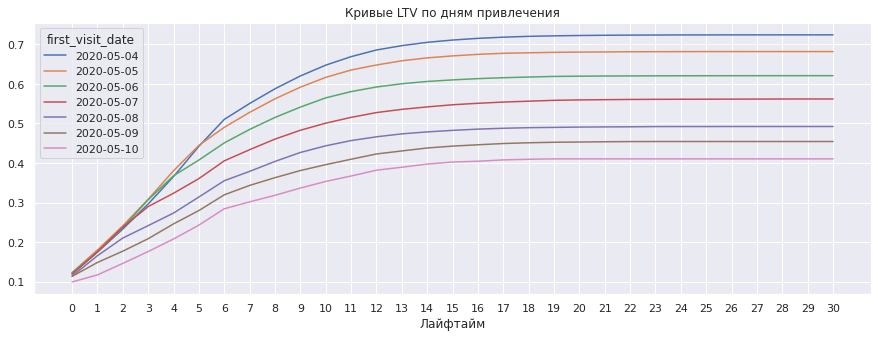

In [63]:
# строим кривые ltv

ltv_report = result.drop(columns = ['cohort_size'])

ltv_report.T.plot(
    grid=True,
    xticks=list(ltv_report.columns.values),
    figsize=(15, 5),
)
plt.xlabel('Лайфтайм')
plt.title('Кривые LTV по дням привлечения')
plt.show()

По графику видно, что прирост LTV для всех когорт останавливается на 14-15 день. Самый высокий LTV у когорт от 4 и 5 мая, самый низкий у 10 мая.

#### LTV с разбивкой по источникам

Посчитаем LTV с разбивкой по источникам:

Добавим в таблицу result_raw информацию об инсточнике, откуда пришел пользователь.

In [64]:
result_raw = result_raw.merge(profiles[['user_id','source']],on='user_id',how='left')
result_raw.head()

,event_datetime,event,building_type,user_id,project_type,event_date,event_hour,event_week,strategy,first_visit,first_visit_date,lifetime,revenue,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,0,19,не прошёл,2020-05-04 00:00:01,2020-05-04,0,0.07,youtube_channel_reklama
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,0,19,проект,2020-05-04 00:00:03,2020-05-04,0,0.07,facebook_ads
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04,0,19,победа над врагом,2020-05-04 00:00:16,2020-05-04,0,0.07,instagram_new_adverts
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04,0,19,не прошёл,2020-05-04 00:00:16,2020-05-04,0,0.07,facebook_ads
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04,0,19,победа над врагом,2020-05-04 00:00:35,2020-05-04,0,0.07,yandex_direct


In [65]:
# строим треугользную таблицу по источникам
source_result = result_raw.pivot_table(index='source',
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

# Посчитатаем сумму выручки с накоплением
source_result = source_result.fillna(0).cumsum(axis=1)

# считаем размеры когорт
source_cohort_sizes = (
            result_raw.groupby('source')
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'source_cohort_size'}))

# объединяем размеры когорт и таблицу выручки
source_result = source_cohort_sizes.join(source_result).fillna(0)

# считатаем LTV
# делим каждую «ячейку» в строке на размер когорты
source_result = source_result.div(source_result['source_cohort_size'], axis=0)
source_result

,source_cohort_size,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
source,,,,,,,,,,,,,,,,,,,,,
facebook_ads,1.0,0.120536,0.175770,0.235627,0.296794,0.360554,0.424622,0.478958,0.514908,0.548676,...,0.669853,0.670213,0.670470,0.670675,0.670829,0.670880,0.670932,0.670983,0.671009,0.671009
instagram_new_adverts,1.0,0.120362,0.173630,0.229513,0.291419,0.353953,0.415775,0.470905,0.507714,0.541993,...,0.664153,0.664655,0.664948,0.665157,0.665261,0.665282,0.665345,0.665366,0.665387,0.665387
yandex_direct,1.0,0.119278,0.173031,0.230781,0.291131,0.352892,0.413068,0.468042,0.503471,0.535194,...,0.653527,0.653847,0.654021,0.654196,0.654239,0.654326,0.654355,0.654370,0.654370,0.654399
youtube_channel_reklama,1.0,0.119829,0.172394,0.229337,0.290346,0.351876,0.411739,0.464304,0.500346,0.533835,...,0.650041,0.650406,0.650719,0.650797,0.650849,0.650927,0.650927,0.650927,0.650953,0.650953


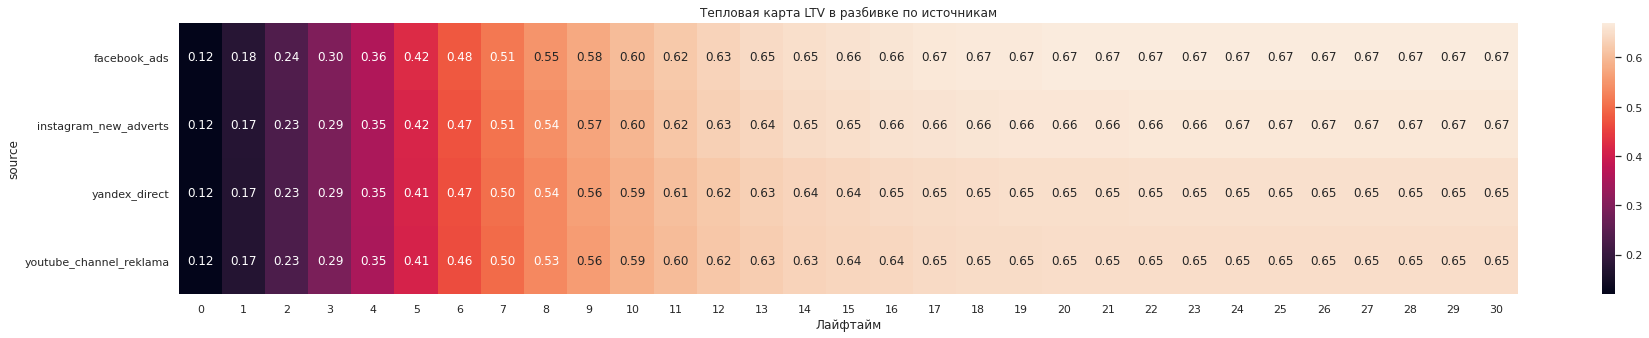

In [66]:
# строим тепловую карту в разбивке по источникам
plt.figure(figsize=(30,5))
sns.heatmap(source_result.drop(columns=['source_cohort_size']), annot=True, fmt='.2f')
plt.title('Тепловая карта LTV в разбивке по источникам')
plt.xlabel('Лайфтайм')
plt.show()

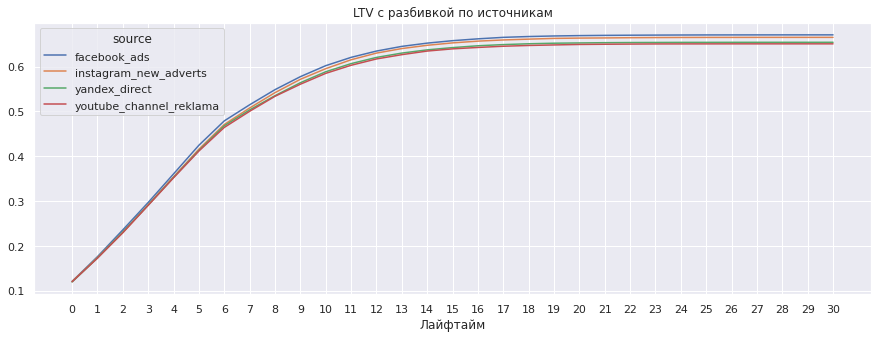

In [67]:
# строим кривые ltv в разбивке по источникам

source_ltv_report = source_result.drop(columns = ['source_cohort_size'])

source_ltv_report.T.plot(
    grid=True,
    xticks=list(source_ltv_report.columns.values),
    figsize=(15, 5),
)
plt.xlabel('Лайфтайм')
plt.title('LTV c разбивкой по источникам')
plt.show()

Различия по LTV у источников минимальны, это значит что пользователи, пришедшие из разных рекламных источников принесли примерно одинаковый доход. Однако само по себе это ничего не значит, нужно соотнести выручку с затратами на рекламу.

### Расчёт CAC

Расчитаем CAC и узнаем, сколько стоило привлечение каждого пользователя.

In [68]:
# добавим дату первого события в отдельный столбец
profiles['dt'] = profiles['first'].dt.date

In [69]:
# считаем количество уникальных пользователей
# с одинаковыми источником и датой привлечения

new_users = (
        profiles.groupby(['dt', 'source'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index())

new_users.head()

,dt,source,unique_users
0,2020-05-04,facebook_ads,1184
1,2020-05-04,instagram_new_adverts,1452
2,2020-05-04,yandex_direct,2078
3,2020-05-04,youtube_channel_reklama,1146
4,2020-05-05,facebook_ads,694


In [70]:
# переименуем столбец day в таблице ad_costs
ad_costs = ad_costs.rename(columns={'day':'dt'})
ad_costs['dt'] = ad_costs['dt'].dt.date

Реклама оплачивается авансом на следующий день, поэтому чтобы корректно добавить САС к пользовательским профилям, нужно прибавить 1 день к датам в таблице ad_costs.

In [71]:
ad_costs['dt'] = ad_costs['dt'] + timedelta(days=1)
ad_costs['dt'].head()

0    2020-05-04
1    2020-05-05
2    2020-05-06
3    2020-05-07
4    2020-05-08
Name: dt, dtype: object

In [72]:
# объединим таблицы
ad_costs_new = ad_costs.merge(new_users, on=['dt', 'source'], how='left')

# делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
ad_costs_new['acquisition_cost'] = ad_costs_new['cost'] / ad_costs_new['unique_users']
ad_costs_new.head()

,source,dt,cost,unique_users,acquisition_cost
0,facebook_ads,2020-05-04,935.882786,1184,0.790442
1,facebook_ads,2020-05-05,548.354480,694,0.790136
2,facebook_ads,2020-05-06,260.185754,345,0.754162
3,facebook_ads,2020-05-07,177.982200,224,0.794563
4,facebook_ads,2020-05-08,111.766796,139,0.804078


In [73]:
# добавим стоимость привлечения в профили
profiles = profiles.merge(
        ad_costs_new[['dt', 'source', 'acquisition_cost']],
        on=['dt', 'source'],
        how='left')
profiles.head()

,user_id,first,last,source,finished,project_finish,timedelta,strategy,first_dt,dt,acquisition_cost
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-20 11:26:06,facebook_ads,False,False,14,не прошёл,2020-05-06,2020-05-06,0.754162
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-18 10:46:52,yandex_direct,False,False,12,не прошёл,2020-05-06,2020-05-06,0.464206
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-14 09:21:27,youtube_channel_reklama,False,False,8,не прошёл,2020-05-05,2020-05-05,0.390759
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,instagram_new_adverts,True,False,6,победа над врагом,2020-05-05,2020-05-05,0.631816
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-22 02:46:45,facebook_ads,False,False,16,не прошёл,2020-05-05,2020-05-05,0.790136


In [74]:
# заменим пропуск на 0
profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

In [75]:
# считаем средний CAC по всему проекту
cac_mean = profiles.query('acquisition_cost != 0')['acquisition_cost'].mean()
cac_mean

0.5600749106355349

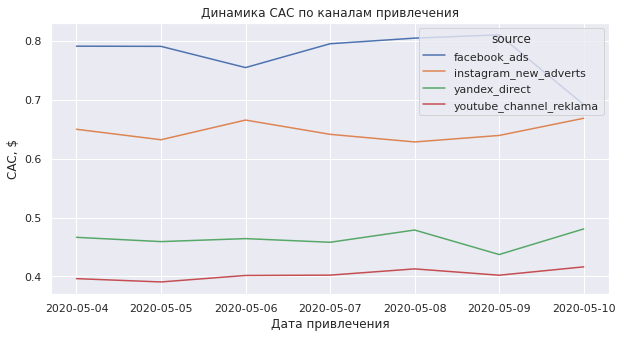

In [76]:
# строим график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='source', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Еще раз убеждаемся, что facebook - самый дорогой источник привлечения игроков, а youtube - самый дешевый.

### Расчёт ROI

Расчитаем окупаемость инвестиций ROI и наконец узнаем, окупается ли наша рекламная кампания при выбранной модели монетизации игры.

In [77]:
# считаем средний CAC по каналам привлечения

cac = (
    profiles.groupby('source')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
)

cac

,cac
source,
facebook_ads,0.785365
instagram_new_adverts,0.645785
yandex_direct,0.463590
youtube_channel_reklama,0.397662


Сверим с САС, рассчитанным ранее, чтобы проверить себя:

In [78]:
source['cost_per_user']

source
facebook_ads               0.785365
instagram_new_adverts      0.645785
yandex_direct              0.463590
youtube_channel_reklama    0.397662
Name: cost_per_user, dtype: float64

Все сходится, САС расчитан правильно.

In [79]:
# делиим LTV в разбивке по источникам на САС
roi = source_result.div(cac['cac'], axis=0)

# восстанавливаем размер когорт после деления
roi.loc[:, 'source_cohort_size'] = source_cohort_sizes['source_cohort_size']
roi

,source_cohort_size,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
source,,,,,,,,,,,,,,,,,,,,,
facebook_ads,2726,0.153477,0.223807,0.300023,0.377906,0.459091,0.540669,0.609854,0.655629,0.698625,...,0.852920,0.853378,0.853705,0.853966,0.854162,0.854228,0.854293,0.854358,0.854391,0.854391
instagram_new_adverts,3347,0.186380,0.268867,0.355402,0.451264,0.548097,0.643830,0.729198,0.786197,0.839278,...,1.028443,1.029220,1.029674,1.029998,1.030160,1.030192,1.030289,1.030322,1.030354,1.030354
yandex_direct,4817,0.257291,0.373242,0.497812,0.627994,0.761216,0.891021,1.009605,1.086027,1.154456,...,1.409710,1.410400,1.410776,1.411152,1.411246,1.411434,1.411497,1.411528,1.411528,1.411591
youtube_channel_reklama,2686,0.301333,0.433519,0.576715,0.730134,0.884864,1.035399,1.167585,1.258221,1.342434,...,1.634658,1.635576,1.636362,1.636559,1.636690,1.636887,1.636887,1.636887,1.636952,1.636952


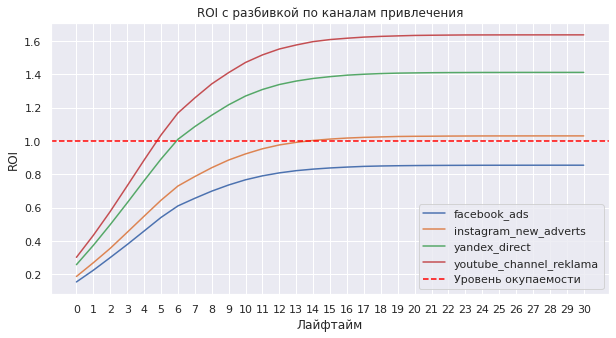

In [80]:
# строим график ROI
roi_report = roi.drop(columns=['source_cohort_size'])
roi_report.T.plot(grid=True, figsize=(10, 5), xticks=list(roi_report.columns.values))

plt.title('ROI с разбивкой по каналам привлечения')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

Реклама в яндексе и на youtube хорошо окупается за первую неделю. Инстрагам окупается еле-еле через 2 недели и почти не приносит прибыли. Facebook не окупается совсем. Рекомендую обратить внимание на рекламу в Facebook и Instagram, в ней явно нужно что-то менять. Возможно, неудачно выбраны сами рекламные объявления, и ожидания игроков не соотвествуют действительности. Необходимо либо изменить рекламную кампанию в этих источниках, либо отказаться от них вообще в пользу Яндекс.Директ и Youtube.

### Максимальный допустимый процент оттока и возможность уменьшения рекламы

Расчитаем, какой процент пользователей мы можем потерять при реализации базовой модели монетизации, не уйдя при этом в минус.

Сразу автоматизируем процесс расчета показателей, напишем функцию которая считает прибыль и максимальный возможный отток пользователей, которыми мы можем пожертвовать, не уйдя в минус. Добавим параметр less_ads, в котором будем указывать, на сколько мы хотим уменьшить количество рекламы. При less_ads = 0 получим расчёт по базовой модели, при добавлении less_ads получим все параметры с учетом уменьшения количества показываемой рекламы на число less_ads.

In [81]:
dict_test = {}

In [82]:
def churn(less_ads,y=1):
    total_revenue = result_raw['revenue'].sum()
    sum_cost = ad_costs['cost'].sum()
    users_count = result_raw['user_id'].nunique()
    revenue_per_user =  total_revenue / users_count
    
    if less_ads == 0:
        churn = round((users_count - int(sum_cost / revenue_per_user)) / users_count * 100,2)
        profit = total_revenue - sum_cost
        
    
    else:
        revenue_change = total_revenue - 0.07 * less_ads * users_count
        revenue_per_user =  revenue_change / users_count
        churn = round((users_count - sum_cost / revenue_per_user) / users_count * 100,2)
        profit = revenue_change - sum_cost
    
    if y== 1:
        
        print('Всего заработали: {}'.format(profit))
        print('Максимальный возможный отток: {}'.format(churn))
    
    dict_test[less_ads] = profit
 

In [83]:
for x in range(0,10):
    churn(x,0)

In [84]:
# запишем profit значения в датафрем 
profitgram = pd.DataFrame(list(dict_test.items()),
                   columns=['less_ads', 'profit']).set_index('less_ads')
profitgram

,profit
less_ads,
0,1353.343013
1,403.023013
2,-547.296987
3,-1497.616987
4,-2447.936987
5,-3398.256987
6,-4348.576987
7,-5298.896987
8,-6249.216987


Построим график прибыли в зависимости от уменьшения показов рекламу.

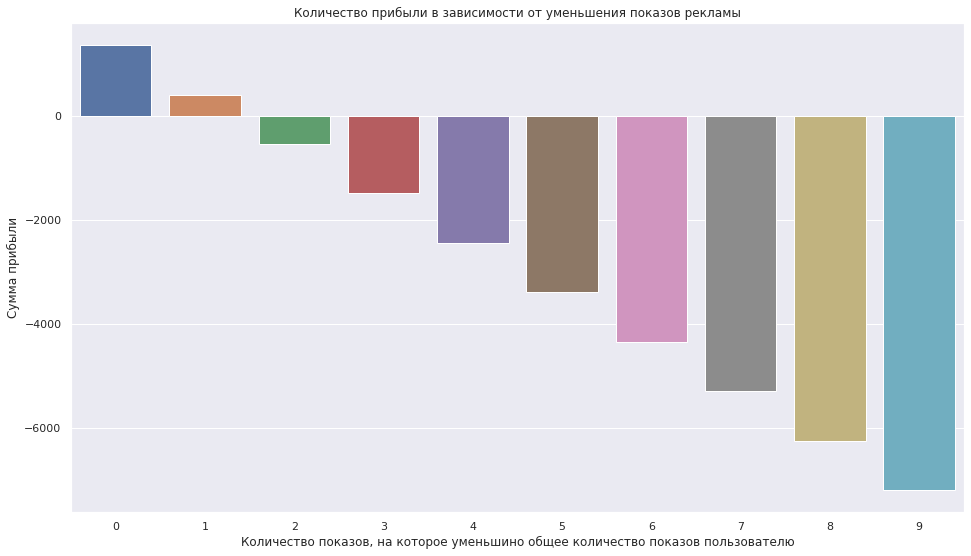

In [85]:
plt.figure(figsize=(16,9))
sns.barplot(data=profitgram,x=profitgram.index,y='profit')
plt.title('Количество прибыли в зависимости от уменьшения показов рекламы')
plt.ylabel('Сумма прибыли')
plt.xlabel('Количество показов, на которое уменьшино общее количество показов пользователю')
plt.show()

График говорит, что максимум того, что мы можем себе позволить - уменьшить количество рекламы для каждого пользователя на 1 показ, например, на первом построенном здании. Дальнейшее уменьшение рекламы приведет к убыткам.

Расчитаем процент максимально допустимый процент оттока для базовой модели и для модели с уменьшением показов на 1.

In [86]:
# базовая модель
churn(0)

Всего заработали: 1353.343013211981
Максимальный возможный отток: 15.11


In [87]:
# уменьшение рекламы на 1 показ 
churn(1)

Всего заработали: 403.0230132119814
Максимальный возможный отток: 5.03


В случае, если мы убираем 1 показ рекламы для каждого пользователи, процент пользователей, которых мы можем потерять всего 5%. Это довольно мало, следовательно модель довольно рискованная, можно уйти в минус.

### Модель монетизации

Расчёты показывают, что в целом модель монетизации, предложенная заказчиком хороша и рентабильна. Она будет приносить прибыль, при этом мы можем допустить, чтобы от нас ушло не более 15% пользователей, возмущенных рекламой. Все пользователи вынуждены строить здания, так что каждый из них будет приносить компании доход. Ранее было расчитано, что пользователи в среднем совершают по 1-2 событию в день, значит и рекламу им придется терпеть всего 1-2 раза за день, объективно это немного и вряд ли приведет к большому оттоку среди игроков.

Был расчитан вариант модели, в котором мы не показываем пользователю рекламу после первого посторенного здания. В этом случае мы можем потерять всего 5% пользователей, что довольно рисковано. Дальнейшее уменьшение рекламы при текущих расходах на привлечение пользователей приведет к убыткам. Это станет возможным только после пересмотра вопроса о распределении рекламных средств, так как ранее мы выяснили что реклама в Facebook приносит убытки, а реклама в Instagram фактически выходит в ноль.

# Общие выводы

* **Общие исследования**

Самые важные выводы, полученные из исследовательского анализа:

* В среднем игроки совершают 1-2 события в день.
* Все игроки вынуждены строить здания, это предусмотрено геймплеем, нет ни одного игрока, не построившего здание.
* 57% игроков из тестовой группы не завершили 1 уровень, 29% завершили уровень через победу над врагом, 14% - через завершение проекта.
* Все игроки построили сборочный цех; игроки, завершившие проект построили все типы зданий; победившие врага предпочитали строить космопорты, а не исследовательские центры
* Завершившие проект в среднем прошли уровень за 13 дней, победившие врага - за 10.
* Пользователи завершившие проект, построили в среднем 13 объектов, а незавершившие - всего 9.
* Удержание пользователей максимально в течение первой недели, дальше показатель падает - игроки переходят на новый уровень.

* **Рекламные источники**

Наиболее рентабельные источники Youtube и Яндекс.Директ, привлечение новых пользователей через них обходится значительно дешевле, чем через Facebook и Instagram. Имеет смысл вкладывать больший процент рекламных средств в Youtube и Яндекс.Директ. Также было выявлено, что "качество" пользователей, пришедших из разных источников одинаковое, то есть пользователи пришедшие из разных источников одинаково хорошо конвертируются - переходят на следующий уровень. 

Однако реклама в Facebook не окупается, а в Instagram окупается очень слабо. Имеет смысл обратить на это внимание и либо переработать рекламную кампанию в этих источниках, либо отказаться от них вообще.

* **Модель монетизации**

Модель монетизации, при которой пользователей смотрит рекламу после каждого построенного объекта, рентабельна и имеет право на жизнь. При такой модели мы можем допустить отток не более чем 15% пользователей, чтобы не уйти в минус. По расчётам при такой модели пользователь будет вынужден смотреть рекламу 1-2 раза в день, это не должно вызвать раздражения среди игроков. 

На данном этапе мы можем избавить пользователей от одной рекламы и не уйти в минус. При условии, что мы не будем показывать рекламу после первого построенного здания, максимально допустимый процент оттока будет 5%, это довольно рисковано, можно уйти в минус. Дальнейшее уменьшение рекламы в игре возможно только в случае пересмотра затрат на рекламу в Facebook, которая не окупается, и Instagam, которая приносит очень маленькую прибыль и фактически выходит в ноль.